# MY

In [6]:
# Dynamic Pricing Simulation for Urban Parking Lots
# Google Colab-ready notebook structure

# === 1. Setup and Imports ===
import numpy as np
import pandas as pd
import pathway as pw            # Pathway streaming SDK
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import gridplot

output_notebook()
# # /content/sample_data/dataset.csv
# # === 2. Load Data ===
# # Mount Drive if dataset stored in Google Drive
# try:
#     from google.colab import drive
#     drive.mount('/content/drive')
# except:
#     pass

# Adjust the path to your CSV
csv_path = '/content/dataset.csv'

# Read CSV with low_memory=False to avoid dtypes issues
df = pd.read_csv(csv_path)
# Combine date and time columns and convert to datetime
# Combine date and time columns and convert to datetime with the correct format
df['timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')
# Drop the original date and time columns
df = df.drop(columns=['LastUpdatedDate', 'LastUpdatedTime'])


In [7]:
# Remove duplicate rows
df = df.drop_duplicates()

# --- Feature Engineering ---
# Extract day of the week and hour of the day
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour_of_day'] = df['timestamp'].dt.hour

# Create occupancy rate feature
df['occupancy_rate'] = df['Occupancy'] / df['Capacity']

# --- Encoding Categorical Variables ---
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['VehicleType', 'TrafficConditionNearby'])

# Display the first few rows of the preprocessed dataframe
print(df.head())

   ID SystemCodeNumber  Capacity   Latitude  Longitude  Occupancy  \
0   0      BHMBCCMKT01       577  26.144536  91.736172         61   
1   1      BHMBCCMKT01       577  26.144536  91.736172         64   
2   2      BHMBCCMKT01       577  26.144536  91.736172         80   
3   3      BHMBCCMKT01       577  26.144536  91.736172        107   
4   4      BHMBCCMKT01       577  26.144536  91.736172        150   

   QueueLength  IsSpecialDay           timestamp  day_of_week  hour_of_day  \
0            1             0 2016-10-04 07:59:00            1            7   
1            1             0 2016-10-04 08:25:00            1            8   
2            2             0 2016-10-04 08:59:00            1            8   
3            2             0 2016-10-04 09:32:00            1            9   
4            2             0 2016-10-04 09:59:00            1            9   

   occupancy_rate  VehicleType_bike  VehicleType_car  VehicleType_cycle  \
0        0.105719             False      

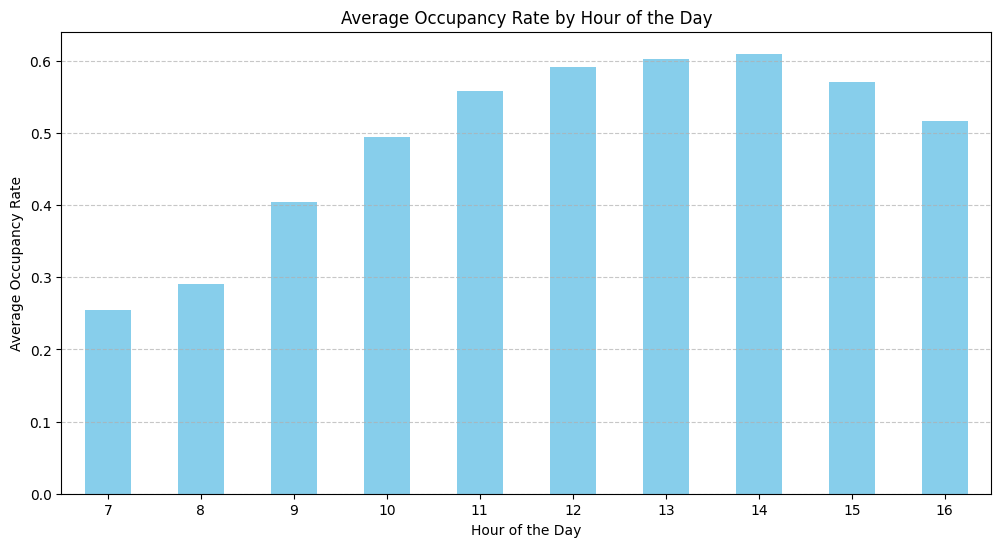

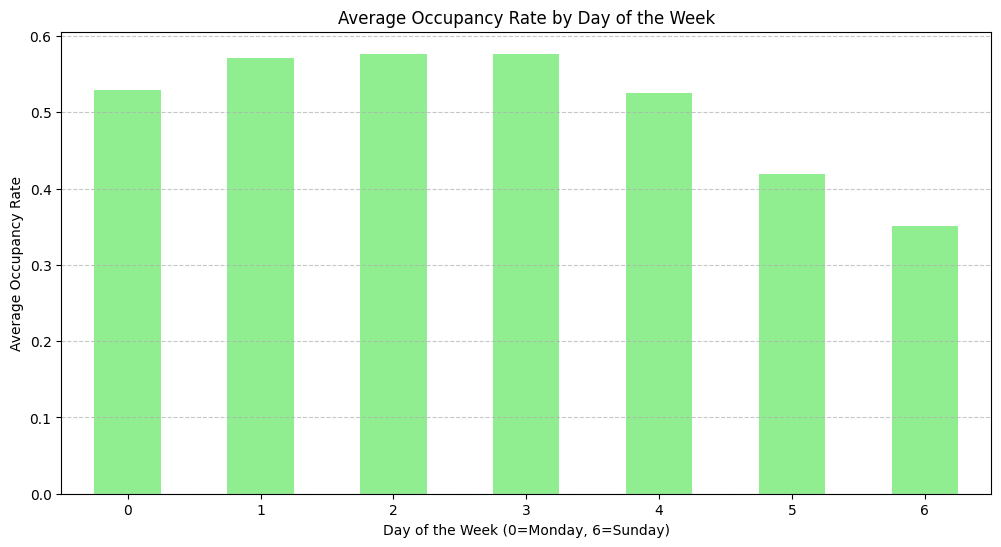

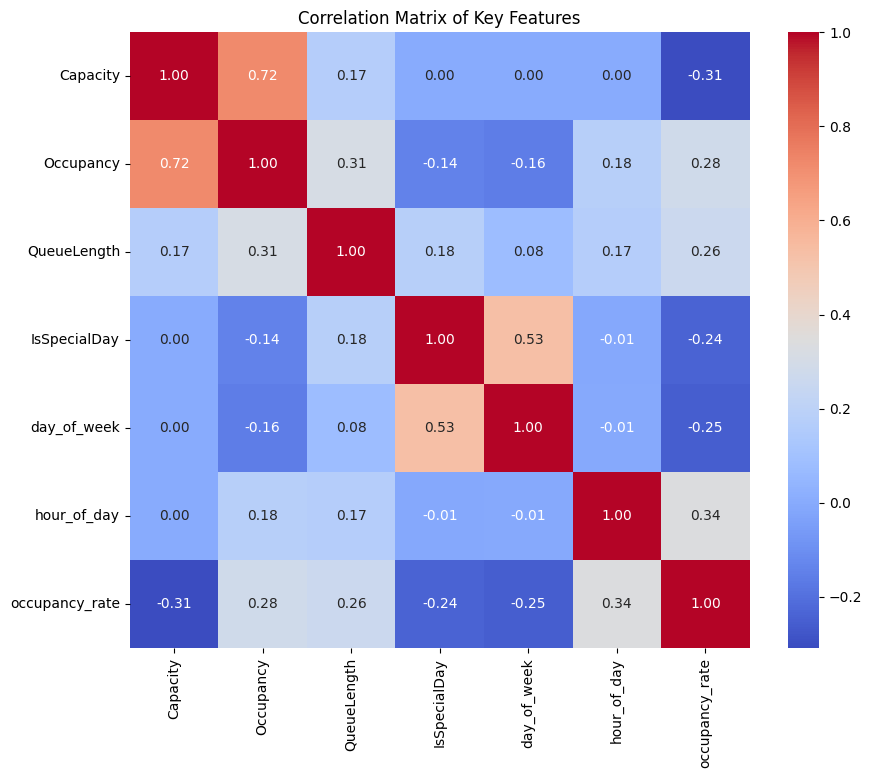

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'timestamp' column is set as the index for time-series plotting
# We add a check to see if 'timestamp' is a column before setting it as the index.
# This prevents an error if you run this cell more than once.
if 'timestamp' in df.columns:
    df.set_index('timestamp', inplace=True)

# --- Plot 1: Average Occupancy Rate by Hour of the Day ---
plt.figure(figsize=(12, 6))
df.groupby('hour_of_day')['occupancy_rate'].mean().plot(kind='bar', color='skyblue')
plt.title('Average Occupancy Rate by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Occupancy Rate')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Plot 2: Average Occupancy Rate by Day of the Week ---
plt.figure(figsize=(12, 6))
df.groupby('day_of_week')['occupancy_rate'].mean().plot(kind='bar', color='lightgreen')
plt.title('Average Occupancy Rate by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Occupancy Rate')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Plot 3: Correlation Matrix Heatmap ---
# We'll select a subset of columns for a cleaner heatmap
corr_cols = ['Capacity', 'Occupancy', 'QueueLength', 'IsSpecialDay', 'day_of_week', 'hour_of_day', 'occupancy_rate']
# For the correlation matrix, we need to make sure we are using columns that are present.
# If df.index is the timestamp, we can use it, but let's stick to the columns for simplicity.
# We'll create a temporary DataFrame for the correlation plot to avoid issues with the index.
plot_df = df.reset_index() # Temporarily move timestamp back to a column for selection
corr_cols = ['Capacity', 'Occupancy', 'QueueLength', 'IsSpecialDay', 'day_of_week', 'hour_of_day', 'occupancy_rate']
# Ensure all columns for correlation exist in the dataframe before trying to create the matrix
corr_cols_exist = [col for col in corr_cols if col in plot_df.columns]
correlation_matrix = plot_df[corr_cols_exist].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Features')
plt.show()

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Select features for the model
# We're dropping Capacity and Occupancy because occupancy_rate captures their relationship.
features = df.drop(columns=['Capacity', 'Occupancy', 'SystemCodeNumber'])

# Scale the features to be between 0 and 1
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# --- Create sequences for the LSTM ---
# We will use the last 24 hours of data (24 steps) to predict the next hour's occupancy.
def create_sequences(data, target_col_index, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # The sequence of features
        X.append(data[i:i + sequence_length])
        # The target value (occupancy_rate) at the next time step
        y.append(data[i + sequence_length, target_col_index])
    return np.array(X), np.array(y)

SEQUENCE_LENGTH = 24 # Using 24 hours of data
TARGET_COLUMN_INDEX = features.columns.get_loc('occupancy_rate') # Index of our target variable

X, y = create_sequences(scaled_features, TARGET_COLUMN_INDEX, SEQUENCE_LENGTH)

# --- Split data into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (14675, 24, 15)
Shape of y_train: (14675,)
Shape of X_test: (3669, 24, 15)
Shape of y_test: (3669,)


In [15]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 594.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.7 MB/s eta 0:00:00


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Build the LSTM Model ---
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1)) # Output layer predicts the single 'occupancy_rate' value

# --- Compile the Model ---
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# --- Train the Model ---
# We'll use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        13,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,701 (135.55 KB)

 Trainable params: 34,701 (135.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0367 - val_loss: 0.0093
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0105 - val_loss: 0.0063
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0077 - val_loss: 0.0044
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0047 - val_loss: 0.0028
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 9/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 10/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0028 - val_loss: 0.0019


Test Loss (MSE): 0.0018722937675192952
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


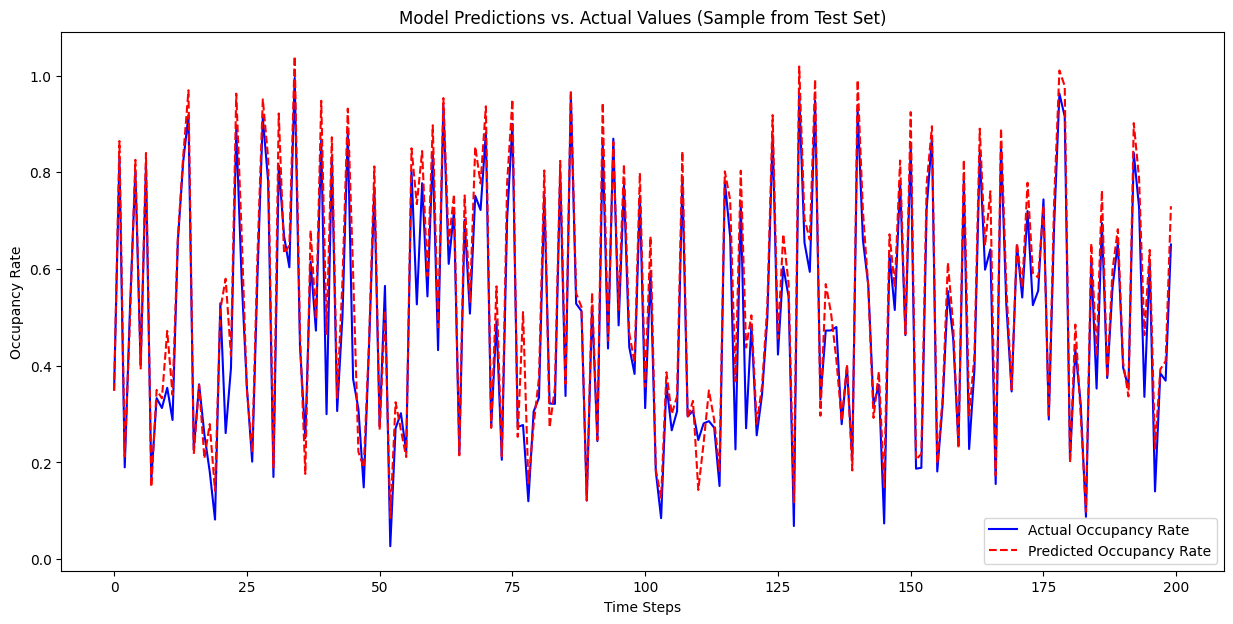

In [17]:
# --- Evaluate the Model ---
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss}")

# --- Make Predictions ---
predictions_scaled = model.predict(X_test)

# --- Inverse Transform Predictions ---
# We need to create a dummy array with the same shape as the scaler expects
# to inverse transform just our target variable.
dummy_array = np.zeros((len(predictions_scaled), scaled_features.shape[1]))
dummy_array[:, TARGET_COLUMN_INDEX] = predictions_scaled.ravel()

# Inverse transform the dummy array
predictions = scaler.inverse_transform(dummy_array)[:, TARGET_COLUMN_INDEX]

# --- Visualize Predictions vs. Actual Values ---
plt.figure(figsize=(15, 7))
plt.plot(y_test[:200], color='blue', label='Actual Occupancy Rate')
plt.plot(predictions[:200], color='red', linestyle='--', label='Predicted Occupancy Rate')
plt.title('Model Predictions vs. Actual Values (Sample from Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Occupancy Rate')
plt.legend()
plt.show()

In [18]:
import numpy as np
import pandas as pd

# --- Pre-requisites (Assume these are already created from previous steps) ---
# model: Your trained Keras LSTM model
# scaler: The MinMaxScaler instance fitted on your training data
# features: The pandas DataFrame containing the preprocessed features
# X_test: Your test data sequences
# SEQUENCE_LENGTH: The length of your input sequences (e.g., 24)
# TARGET_COLUMN_INDEX: The index of 'occupancy_rate' in your feature columns

# --- 1. Forecasting Function ---
# This function takes a sequence of recent data and predicts the next occupancy rate.

def predict_occupancy(input_sequence, model, scaler):
    """
    Predicts the next time step's occupancy rate based on an input sequence.

    Args:
        input_sequence (np.array): A numpy array of shape (SEQUENCE_LENGTH, num_features)
                                   representing the most recent data.
        model (keras.Model): The trained LSTM model.
        scaler (MinMaxScaler): The scaler used to transform the training data.

    Returns:
        float: The predicted occupancy rate for the next time step.
    """
    # Reshape the input to (1, SEQUENCE_LENGTH, num_features) for the model
    input_sequence = np.expand_dims(input_sequence, axis=0)

    # Predict the scaled occupancy rate
    predicted_scaled_rate = model.predict(input_sequence)[0][0]

    # To inverse transform, we need to create a dummy array that matches the
    # shape the scaler expects (number of samples, number of features).
    dummy_array = np.zeros((1, scaler.n_features_in_))
    dummy_array[0, TARGET_COLUMN_INDEX] = predicted_scaled_rate

    # Inverse transform the dummy array to get the prediction in the original scale
    predicted_rate = scaler.inverse_transform(dummy_array)[0, TARGET_COLUMN_INDEX]

    # Ensure the prediction is within a logical range [0, 1]
    return np.clip(predicted_rate, 0, 1)


# --- 2. Dynamic Pricing Function ---
# This function implements the pricing logic based on the predicted occupancy.

def get_dynamic_price(predicted_occupancy_rate, base_price=10.0):
    """
    Calculates a dynamic price based on the predicted occupancy rate.

    Args:
        predicted_occupancy_rate (float): The forecasted occupancy rate (0 to 1).
        base_price (float, optional): The standard price for parking. Defaults to 10.0.

    Returns:
        tuple: A tuple containing the calculated price (float) and the pricing tier (str).
    """
    if predicted_occupancy_rate > 0.9:
        # Very High Occupancy: Surge pricing to maximize revenue and free up space
        price = base_price * 2.0
        tier = "Surge"
    elif predicted_occupancy_rate > 0.75:
        # High Occupancy: Increase price
        price = base_price * 1.5
        tier = "High Demand"
    elif predicted_occupancy_rate < 0.4:
        # Low Occupancy: Offer a discount to attract drivers
        price = base_price * 0.8
        tier = "Discount"
    else:
        # Medium Occupancy: Standard pricing
        price = base_price
        tier = "Standard"

    return round(price, 2), tier


# --- 3. Simulation: Putting It All Together ---
# Let's simulate a real-time scenario using a sample from our test data.

print("--- Running Real-Time Pricing Simulation ---")

# Select a random sequence from the test set to simulate "live" data
# In a real application, this would be the actual most recent 24 hours of data.
sample_index = np.random.randint(0, len(X_test))
live_data_sequence = X_test[sample_index]

# Step 1: Forecast the next hour's occupancy
predicted_rate = predict_occupancy(live_data_sequence, model, scaler)

# Step 2: Determine the dynamic price based on the forecast
dynamic_price, price_tier = get_dynamic_price(predicted_rate)

# Step 3: Display the results
print(f"Predicted Occupancy Rate for the next hour: {predicted_rate:.2%}")
print(f"Pricing Tier: {price_tier}")
print(f"Recommended Dynamic Price: ${dynamic_price:.2f}")

print("\n--- Simulation Complete ---")

# You can loop through several samples to see how the price changes
print("\n--- Running a few more examples ---")
for i in range(5):
    sample_index = np.random.randint(0, len(X_test))
    live_data_sequence = X_test[sample_index]
    predicted_rate = predict_occupancy(live_data_sequence, model, scaler)
    dynamic_price, price_tier = get_dynamic_price(predicted_rate)
    print(f"\nExample {i+1}:")
    print(f"  -> Predicted Occupancy: {predicted_rate:.2%}")
    print(f"  -> Recommended Price: ${dynamic_price:.2f} ({price_tier})")



--- Running Real-Time Pricing Simulation ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Occupancy Rate for the next hour: 20.48%
Pricing Tier: Discount
Recommended Dynamic Price: $8.00

--- Simulation Complete ---

--- Running a few more examples ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

Example 1:
  -> Predicted Occupancy: 34.40%
  -> Recommended Price: $8.00 (Discount)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Example 2:
  -> Predicted Occupancy: 83.99%
  -> Recommended Price: $15.00 (High Demand)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Example 3:
  -> Predicted Occupancy: 22.86%
  -> Recommended Price: $8.00 (Discount)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Example 4:
  -> Predicted Occupancy: 43.06%
  -> Recommended Price: $10.00 (Standard)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Example 5:
  -> Predicted Occupancy: 82.98%
  -> Recommended Price: $15.00 (High Demand)
